<a href="https://colab.research.google.com/github/Hwarriach/Plant_Village_Prediction/blob/main/Plant_Village_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Plant Village Project/PlantVillage",
    shuffle = True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
class_names[label[1]]

NameError: ignored

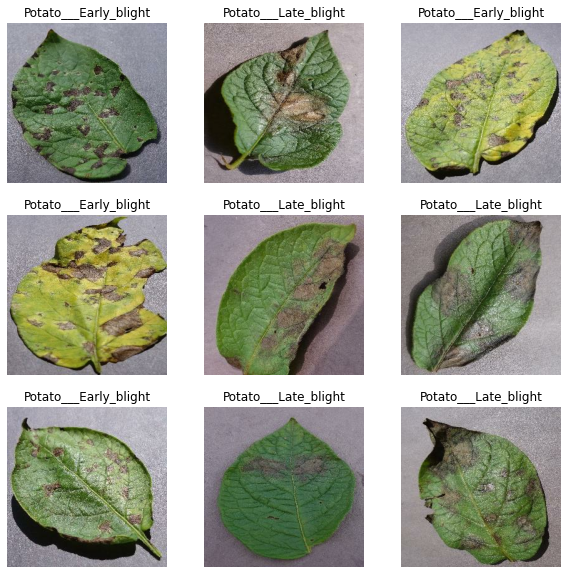

In [8]:
plt.figure(figsize=(10,10))
for image, label in dataset.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image[i].numpy().astype('int'))
    plt.title(class_names[label[i]])
    plt.axis("off")


**Splitting Data**

In [9]:
len(dataset)

68

In [ ]:
# Method 1
"""train_ds = dataset.take(54)
test_ds = dataset.skip(54)
val_ds = test_ds.take(6)
test_ds = test_ds.skip(6)""" 

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

  ds_size=len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
train_ds

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
len(train_ds)

54

In [14]:
len(val_ds)

6

In [15]:
len(test_ds)

8

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**PreProcessing**

In [17]:
# Rescaling and Resizing
rr = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [18]:
# Data Augmentation by flipping and roating existing images
flip = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [28]:
# Convolution layer
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)


model = models.Sequential([
    rr,
    flip,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax'),
])

model.build(input_shape=input_shape)

In [29]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [30]:
#compiling the CNN

model.compile(
    optimizer = 'adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics = ['accuracy'])

In [35]:
epochs = 20

In [36]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=epochs,
)

Epoch 1/20
54/54 [==============================] - 127s 2s/step - loss: 0.1862 - accuracy: 0.9346 - val_loss: 0.1630 - val_accuracy: 0.9375
Epoch 2/20
54/54 [==============================] - 127s 2s/step - loss: 0.2043 - accuracy: 0.9196 - val_loss: 0.1876 - val_accuracy: 0.9219
Epoch 3/20
54/54 [==============================] - 127s 2s/step - loss: 0.1429 - accuracy: 0.9520 - val_loss: 0.2272 - val_accuracy: 0.9115
Epoch 4/20
54/54 [==============================] - 127s 2s/step - loss: 0.1593 - accuracy: 0.9421 - val_loss: 0.1768 - val_accuracy: 0.9323
Epoch 5/20
54/54 [==============================] - 126s 2s/step - loss: 0.1251 - accuracy: 0.9595 - val_loss: 0.1882 - val_accuracy: 0.9375
Epoch 6/20
54/54 [==============================] - 126s 2s/step - loss: 0.1533 - accuracy: 0.9433 - val_loss: 0.1209 - val_accuracy: 0.9635
Epoch 7/20
54/54 [==============================] - 126s 2s/step - loss: 0.1264 - accuracy: 0.9514 - val_loss: 0.1208 - val_accuracy: 0.9531
Epoch 8/20
54

In [37]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 8s 576ms/step - loss: 0.0237 - accuracy: 0.9922


Plotting Loss Curves

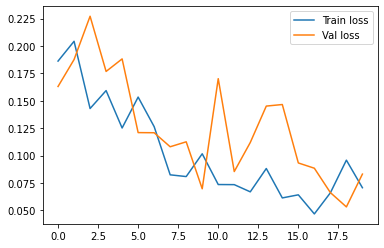

In [38]:
plt.plot(range(epochs), history.history["loss"], label="Train loss" )
plt.plot(range(epochs), history.history["val_loss"], label="Val loss")
plt.legend(loc="upper right")
plt.show()

**Prediction on sample image**

first image to predict
actual label: Potato___healthy
predicted label: Potato___healthy


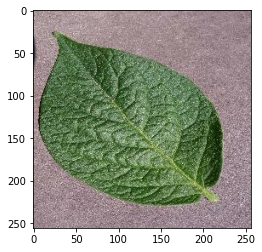

In [39]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])